In [41]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from itertools import cycle

# Import models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression


In [42]:
import os
# Constants
RANDOM_STATE = 42
CV_SPLITS = 10

RESULTS_DIR = 'results/Product_Classification_results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Cell 2: Load Best Parameters and Create Models
def load_best_parameters():
    """Load best parameters from JSON file"""
    with open('hyperparameter_tuning/LDA_product_type_results.json', 'r') as f:
        return json.load(f)

def create_models(best_params, scenario='with_storage_condition'):
    """Create models with best parameters"""
    models = {}
    params = best_params[scenario]
    
    for model_name, model_params in params.items():
        if model_name == 'SVM':
            models[model_name] = SVC(**model_params, random_state= RANDOM_STATE, probability=True)
        elif model_name == 'Random Forest':
            models[model_name] = RandomForestClassifier(**model_params, random_state= RANDOM_STATE)
        elif model_name == 'KNN':
            models[model_name] = KNeighborsClassifier(**model_params)
        elif model_name == 'Neural Network':
            models[model_name] = MLPClassifier(**model_params, random_state= RANDOM_STATE)
        elif model_name == 'Logistic Regression':
            models[model_name] = LogisticRegression(**model_params, random_state= RANDOM_STATE)
    
    return models


# Visualization Functions

In [43]:
# Visualization Functions
def plot_model_comparison(results_without, results_with):
    """Plot model comparison bar chart"""
    models = list(results_without.keys())
    
    means_without = [results_without[model]['mean_accuracy'] for model in models]
    stds_without = [results_without[model]['std_accuracy'] for model in models]
    
    means_with = [results_with[model]['mean_accuracy'] for model in models]
    stds_with = [results_with[model]['std_accuracy'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, means_without, width, yerr=stds_without,
                    label='Without Storage Condition', capsize=5)
    rects2 = ax.bar(x + width/2, means_with, width, yerr=stds_with,
                    label='With Storage Condition', capsize=5)
    
    ax.set_ylabel('Mean Accuracy')
    ax.set_title('Model Comparison for Product Type Classification')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR,'product_type_comparison.png'))
    plt.show()

In [44]:
def plot_confusion_matrices(results_without, results_with, class_labels):
    """Plot confusion matrices side by side for with/without storage condition"""
    for model_name in results_without.keys():
        # Create two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot first confusion matrix (Without Product Type)
        sns.heatmap(results_without[model_name]['confusion_matrix'], 
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=range(len(class_labels)),
                   yticklabels=range(len(class_labels)), ax=ax1)
        ax1.set_title(f'{model_name} - Without Storage Condition')
        ax1.set_ylabel('Actual')
        ax1.set_xlabel('Predicted')
        
        # Plot second confusion matrix (With Product Type)
        sns.heatmap(results_with[model_name]['confusion_matrix'], 
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=range(len(class_labels)),
                   yticklabels=range(len(class_labels)), ax=ax2)
        ax2.set_title(f'{model_name} - With Storage Condition')
        ax2.set_ylabel('Actual')
        ax2.set_xlabel('Predicted')
        
        plt.tight_layout()
        filename = f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png'
        plt.savefig(os.path.join(RESULTS_DIR, filename))
        plt.show()
        


In [45]:
        
def plot_learning_curves(X, y, model, model_name, cv=CV_SPLITS):
    """Plot learning curves with confidence intervals"""
    train_sizes = np.linspace(0.1, 1.0, 10)
    #cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=train_sizes,
        cv=cv,
        n_jobs=-1,
        scoring='accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.15, color='blue')
    plt.plot(train_sizes, val_mean, label='Cross-validation Score', color='red', marker='o')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.15, color='red')
    
    plt.title(f'Learning Curves - {model_name}')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='lower right')
    
    final_train = f"Final training score: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}"
    final_val = f"Final validation score: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}"
    plt.annotate(final_train, xy=(0.6, 0.2), xycoords='axes fraction')
    plt.annotate(final_val, xy=(0.6, 0.15), xycoords='axes fraction')
    
    plt.tight_layout()
    filename = f'learning_curve_{model_name.lower().replace(" ", "_")}.png'
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.show()
    
    return {
        'train_sizes': train_sizes,
        'train_scores': {'mean': train_mean, 'std': train_std},
        'val_scores': {'mean': val_mean, 'std': val_std}
    }

In [46]:

def perform_statistical_analysis(results_without, results_with):
    """Perform statistical analysis"""
    analysis_results = []
    
    print("\nStatistical Analysis Results:")
    print("="*50)
    
    for model in results_without.keys():
        acc_without = results_without[model]['fold_accuracies']
        acc_with = results_with[model]['fold_accuracies']
        
        t_stat, p_value = stats.ttest_rel(acc_with, acc_without)
        improvement = (np.mean(acc_with) - np.mean(acc_without)) * 100
        
        result = {
            'Model': model,
            'Accuracy without Storage Condition': f"{np.mean(acc_without):.4f} ± {np.std(acc_without):.4f}",
            'Accuracy with Storage Condition': f"{np.mean(acc_with):.4f} ± {np.std(acc_with):.4f}",
            'Improvement (%)': f"{improvement:.2f}%",
            'p-value': f"{p_value:.4f}",
            'Significant': "Yes" if p_value < 0.05 else "No"
        }
        analysis_results.append(result)
        
        print(f"\n{model}:")
        print(f"- Without Storage Condition: {result['Accuracy without Storage Condition']}")
        print(f"- With Storage Condition: {result['Accuracy with Storage Condition']}")
        print(f"- Improvement: {result['Improvement (%)']}")
        print(f"- Statistical Significance (p < 0.05): {result['Significant']} (p = {result['p-value']})")

    results_df = pd.DataFrame(analysis_results)
    results_df.to_csv('Product_type_statistical_analysis_results.csv', index=False)
    return results_df
    


# Data Preparation

In [47]:
# Data Preparation
def prepare_data():
    """Load and prepare data consistently"""
    print("Loading data and preparing features...")
    data = pd.read_csv('augmented_bakery_data.csv')
    
    # Encode labels
    le_product = LabelEncoder()
    le_storage = LabelEncoder()
    data['Product_Type_encoded'] = le_product.fit_transform(data['Product_Type'])
    data['Storage_Condition_encoded'] = le_storage.fit_transform(data['Storage_Condition'])
    
    # Prepare features
    feature_cols = [col for col in data.columns if col.startswith(('gain_', 'phase_'))]
    X_base = data[feature_cols]
    
    # Scale features on entire dataset
    scaler = StandardScaler()
    X_base_scaled = scaler.fit_transform(X_base)
    
    # Prepare datasets
    X_without_storage = X_base_scaled
    X_with_storage = np.column_stack([X_base_scaled, data['Storage_Condition_encoded'].values.reshape(-1, 1)])
    
    #target
    y_product = data['Product_Type_encoded'].values
    
    return X_with_storage, X_without_storage, y_product, le_product.classes_


# Model Evaluation

In [48]:
from sklearn.calibration import cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

def evaluate_models(X, y, models, cv=CV_SPLITS):
    """Evaluate models using cross-validation with scikit-learn built-in functions and LDA"""
    results = {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    num_classes = len(np.unique(y))  # Number of unique classes in the target variable
    
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        
        # Create a pipeline with LDA and the model
        pipeline = Pipeline([
            ('lda', LDA(n_components=num_classes - 1)),  # LDA for dimensionality reduction
            (model_name, model)  # The model to evaluate
        ])
        
        # Use cross_val_score to compute fold-wise accuracies
        cv_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
        
        # Use cross_val_predict to get predictions for the entire dataset
        y_pred = cross_val_predict(pipeline, X, y, cv=skf, n_jobs=-1)
        
        # Calculate metrics
        mean_accuracy = cv_scores.mean()
        std_accuracy = cv_scores.std()
        conf_matrix = confusion_matrix(y, y_pred)
        clf_report = classification_report(y, y_pred)
        
        # Store results
        results[model_name] = {
            'fold_accuracies': cv_scores,
            'mean_accuracy': mean_accuracy,
            'std_accuracy': std_accuracy,
            'confusion_matrix': conf_matrix,
            'classification_report': clf_report
        }
        
        # Print results
        print(f"\n{model_name} Final Results:")
        print(f"Mean accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
        print("\nClassification Report:")
        print(clf_report)
    
    return results

In [49]:
def save_analysis_summary(results_without, results_with, stats_results):
    """Generate and save comprehensive analysis summary"""
    
    with open('Product_type_analysis_summary.txt', 'w') as f:
        # Header
        f.write("Product Type Classification Analysis Summary\n")
        f.write("==================================================\n\n")
        
        # 1. Best Performing Models section
        f.write("1. Best Performing Models:\n\n")
        
        # Find best models
        best_without = max(results_without.items(), 
                         key=lambda x: x[1]['mean_accuracy'])
        best_with = max(results_with.items(), 
                       key=lambda x: x[1]['mean_accuracy'])
        
        # Without Storage Condition 
        f.write("Without Storage Condition:\n")
        f.write(f"- Best Model: {best_without[0]}\n")
        f.write(f"- Accuracy: {best_without[1]['mean_accuracy']:.4f} ± "
                f"{best_without[1]['std_accuracy']:.4f}\n\n")
        
        # With Storage Condition
        f.write("With Storage Condition:\n")
        f.write(f"- Best Model: {best_with[0]}\n")
        f.write(f"- Accuracy: {best_with[1]['mean_accuracy']:.4f} ± "
                f"{best_with[1]['std_accuracy']:.4f}\n\n")
        
        # 2. Impact of Storage Condition section
        f.write("2. Impact of Storage Condition:\n")
        
        # Create DataFrame for formatted table
        data = []
        for model_name in results_without.keys():
            acc_without = results_without[model_name]['mean_accuracy']
            std_without = results_without[model_name]['std_accuracy']
            
            acc_with = results_with[model_name]['mean_accuracy']
            std_with = results_with[model_name]['std_accuracy']
            
            improvement = ((acc_with - acc_without) / acc_without) * 100
            
            # Get p-value from stats_results DataFrame
            p_value = float(stats_results[stats_results['Model'] == model_name]['p-value'].values[0].strip())
            
            data.append({
                'Model': model_name,
                'Accuracy without Storage Condition': f"{acc_without:.4f} ± {std_without:.4f}",
                'Accuracy with Storage Condition': f"{acc_with:.4f} ± {std_with:.4f}",
                'Improvement (%)': f"{improvement:.2f}%",
                'p-value': f"{p_value:.4f}",
                'Significant': 'Yes' if p_value < 0.05 else 'No'
            })
        
        # Convert to DataFrame and write as formatted table
        df = pd.DataFrame(data)
        f.write(df.to_string(index=False))
        
        # Additional Analysis
        f.write("\n\n3. Additional Insights:\n")
        f.write("-----------------------\n")
        
        # Count models with significant improvement
        significant_improvements = sum(1 for d in data if float(d['Improvement (%)'].strip('%')) > 0 
                                    and d['Significant'] == 'Yes')
        f.write(f"\nNumber of models with significant improvement: {significant_improvements}\n")
        
        # Best improvement
        best_improvement = max(data, key=lambda x: float(x['Improvement (%)'].strip('%')))
        f.write(f"Model with best improvement: {best_improvement['Model']} "
                f"({best_improvement['Improvement (%)']})\n")
        
        # Overall recommendation
        f.write("\nOverall Recommendation:\n")
        if significant_improvements > 0:
            f.write("Including storage condition information appears beneficial for classification performance.\n")
        else:
            f.write("Storage condition information does not significantly improve classification performance.\n")

# Main Execution

Loading data and preparing features...
Loading best parameters and creating models...

Evaluating models with storage condition...

Evaluating SVM...

SVM Final Results:
Mean accuracy: 0.5222 ± 0.0619

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.63      0.57        90
           1       0.53      0.41      0.46        90

    accuracy                           0.52       180
   macro avg       0.52      0.52      0.52       180
weighted avg       0.52      0.52      0.52       180


Evaluating Random Forest...

Random Forest Final Results:
Mean accuracy: 0.7278 ± 0.0911

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73        90
           1       0.73      0.73      0.73        90

    accuracy                           0.73       180
   macro avg       0.73      0.73      0.73       180
weighted avg       0.73      0.73      0.73       180


Evalua

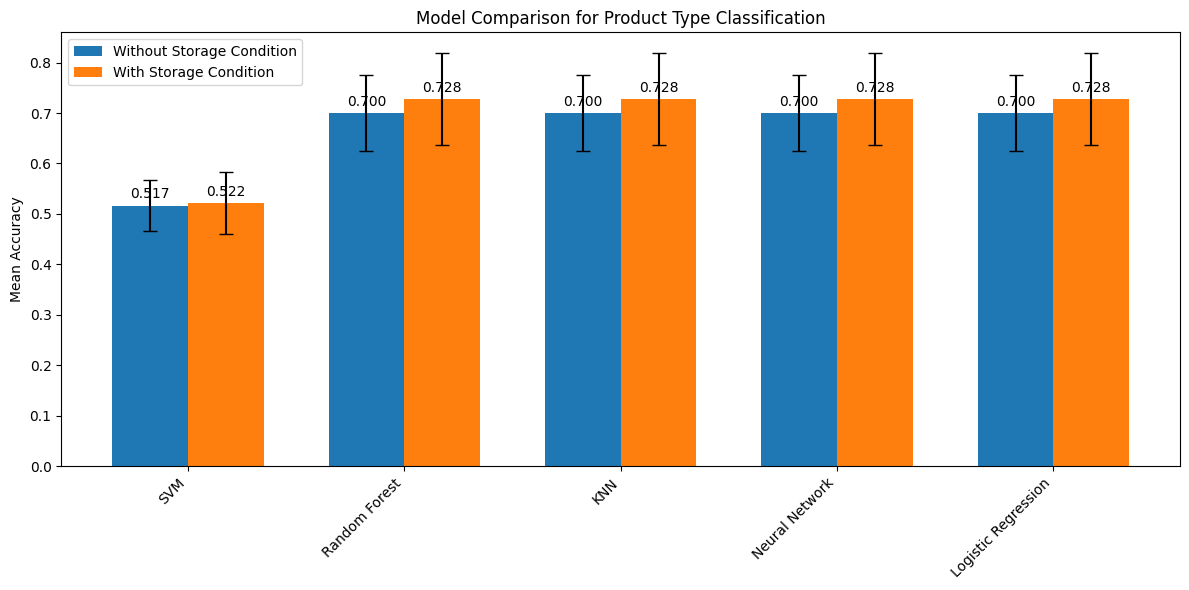

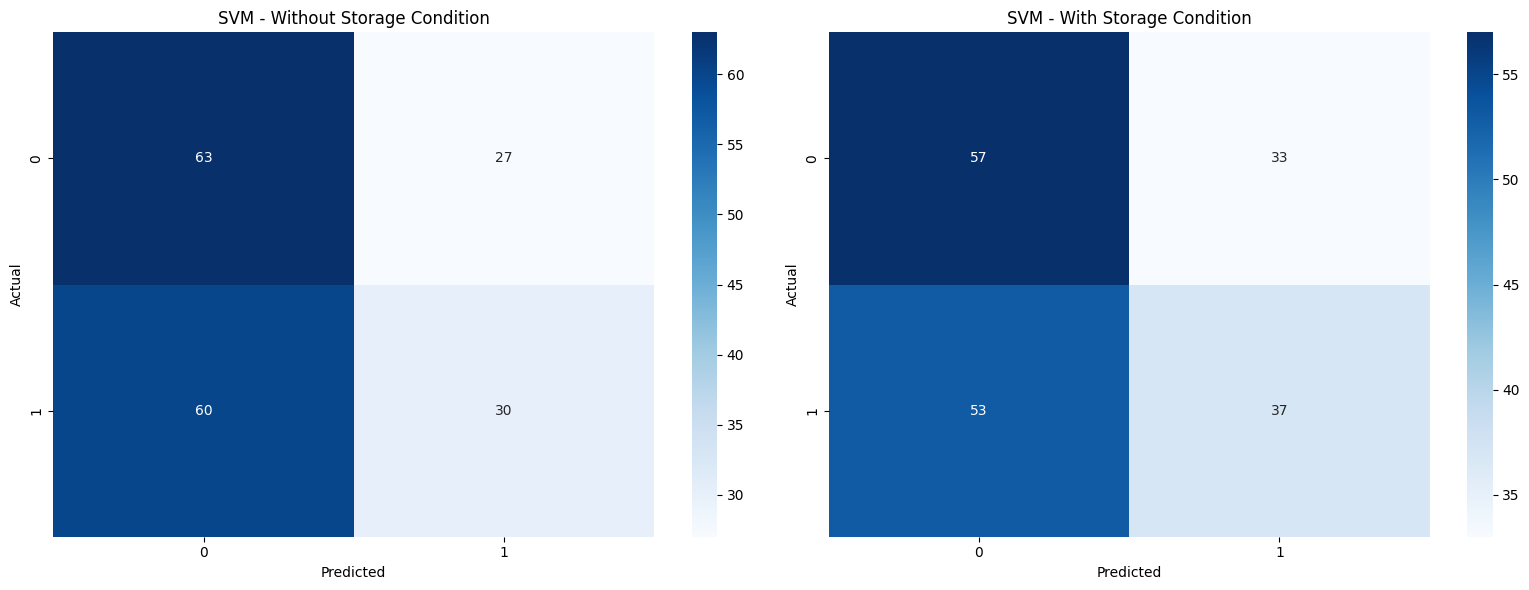

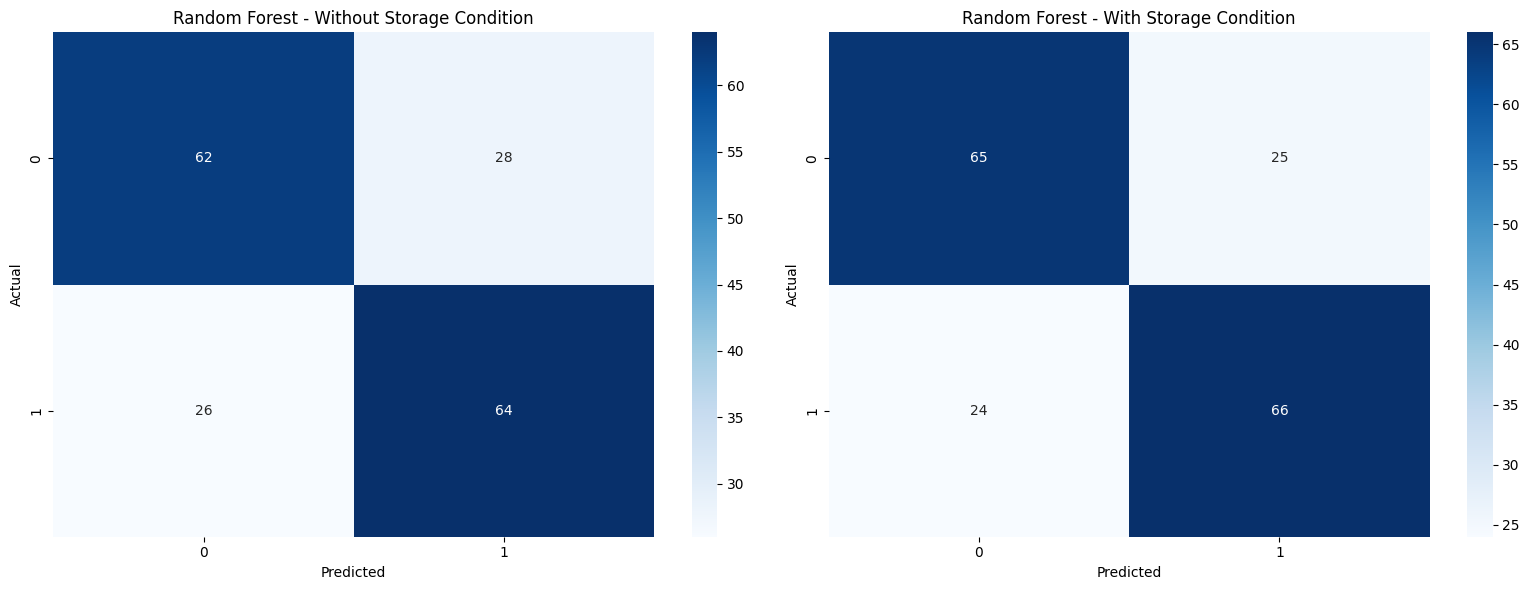

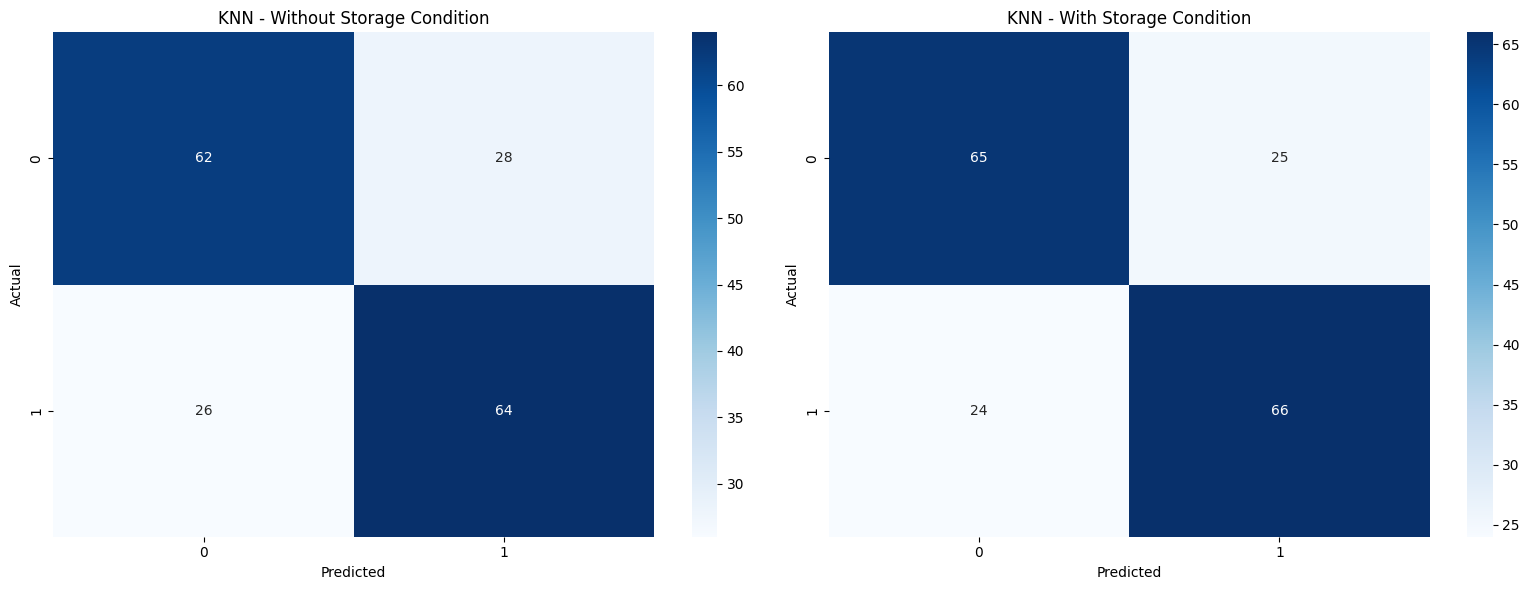

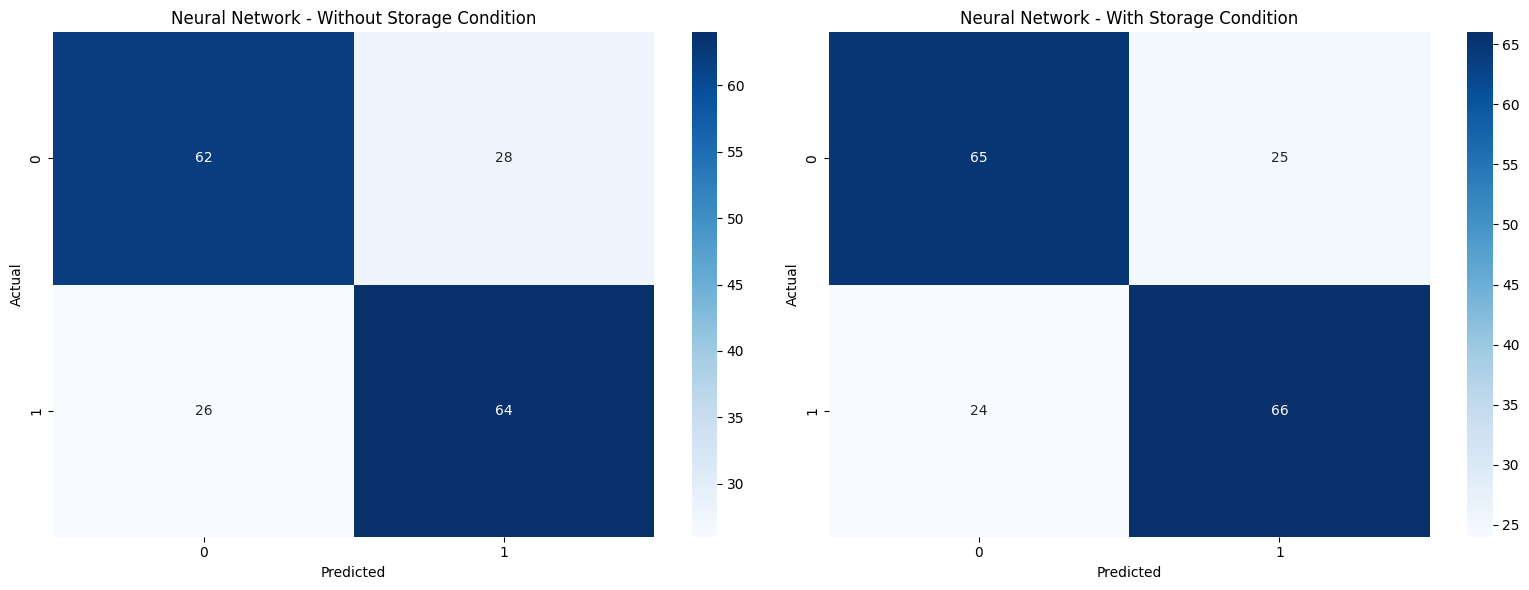

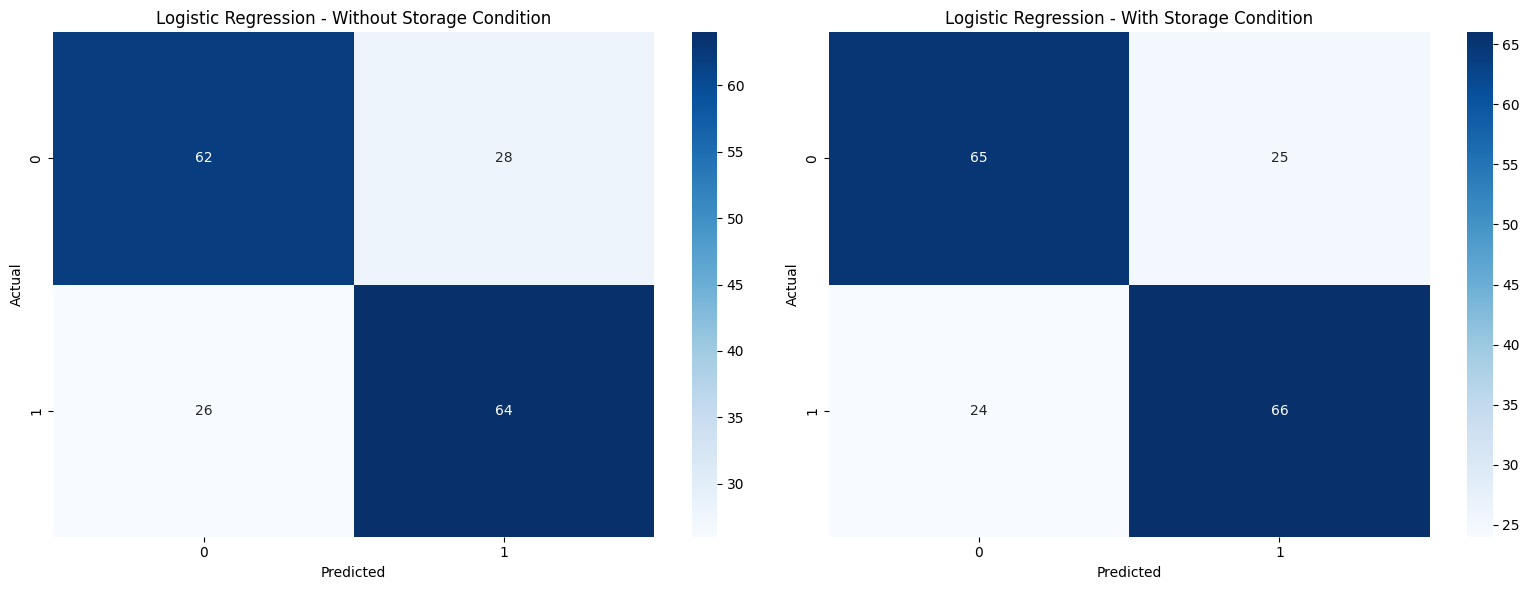


Statistical Analysis Results:

SVM:
- Without Storage Condition: 0.5167 ± 0.0500
- With Storage Condition: 0.5222 ± 0.0619
- Improvement: 0.56%
- Statistical Significance (p < 0.05): No (p = 0.6783)

Random Forest:
- Without Storage Condition: 0.7000 ± 0.0754
- With Storage Condition: 0.7278 ± 0.0911
- Improvement: 2.78%
- Statistical Significance (p < 0.05): No (p = 0.1382)

KNN:
- Without Storage Condition: 0.7000 ± 0.0754
- With Storage Condition: 0.7278 ± 0.0911
- Improvement: 2.78%
- Statistical Significance (p < 0.05): No (p = 0.1382)

Neural Network:
- Without Storage Condition: 0.7000 ± 0.0754
- With Storage Condition: 0.7278 ± 0.0911
- Improvement: 2.78%
- Statistical Significance (p < 0.05): No (p = 0.1382)

Logistic Regression:
- Without Storage Condition: 0.7000 ± 0.0754
- With Storage Condition: 0.7278 ± 0.0911
- Improvement: 2.78%
- Statistical Significance (p < 0.05): No (p = 0.1382)

Generating learning curve for SVM...


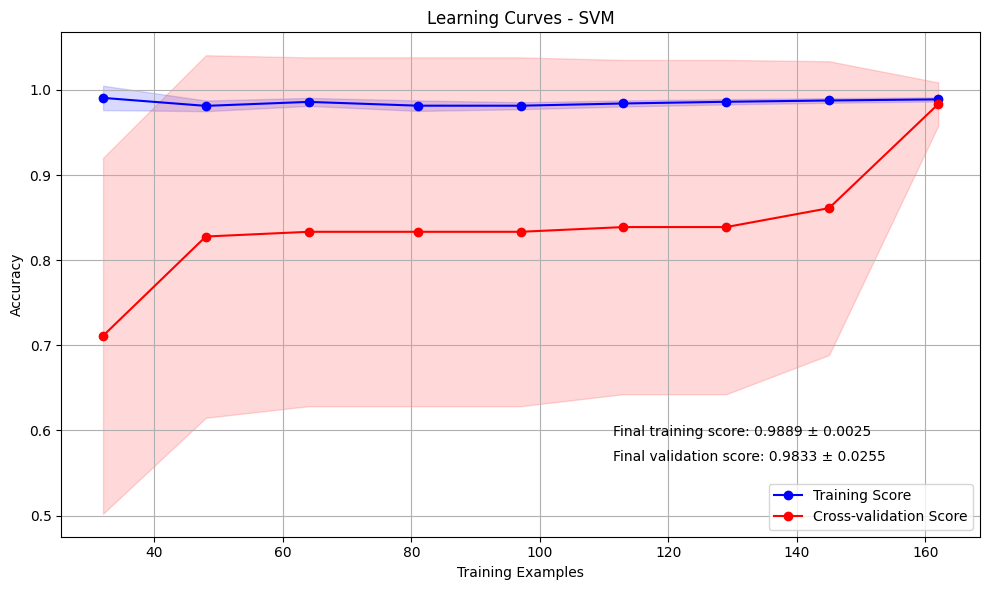


Generating learning curve for Random Forest...


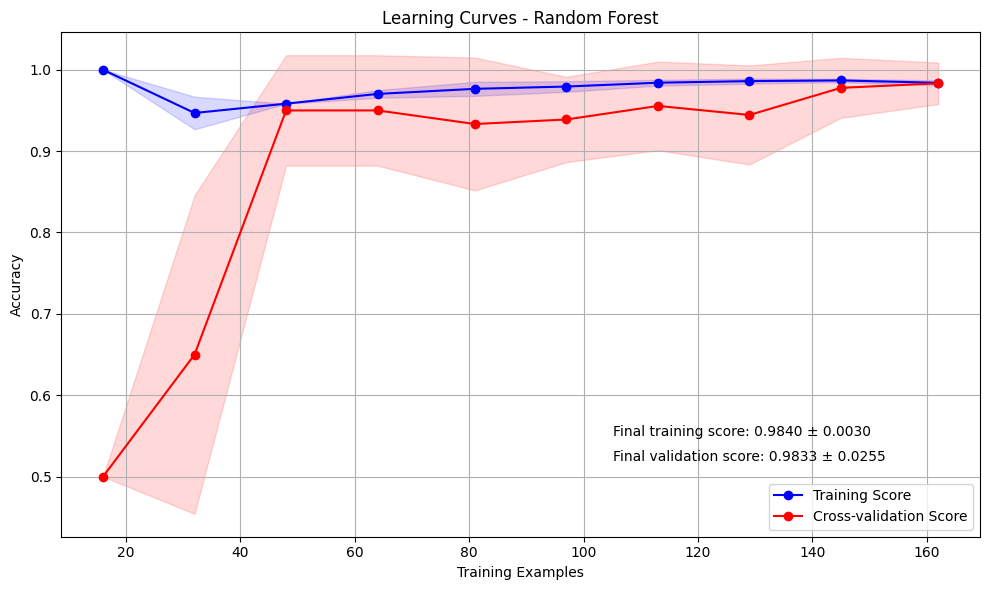


Generating learning curve for KNN...


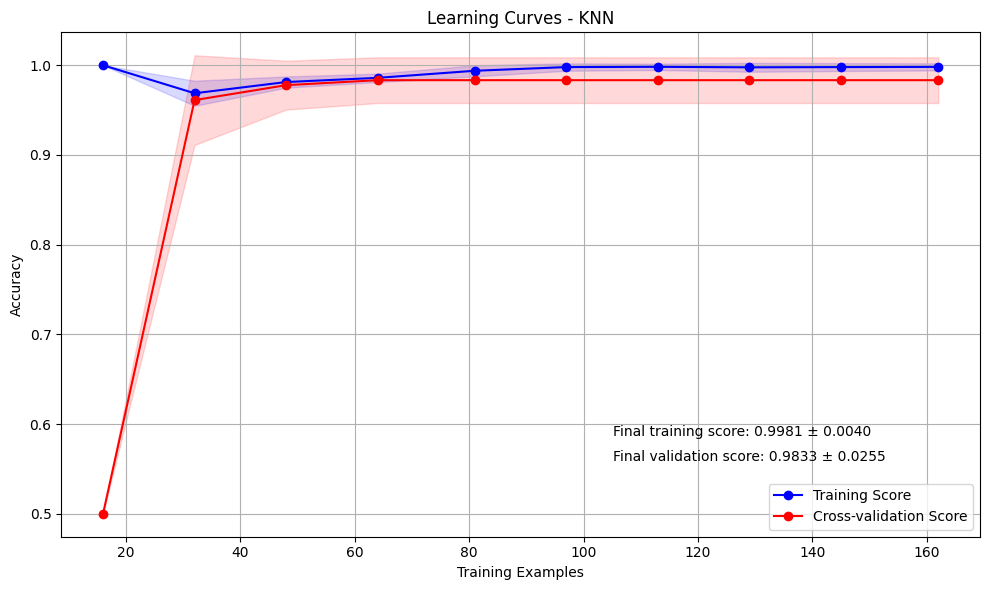


Generating learning curve for Neural Network...


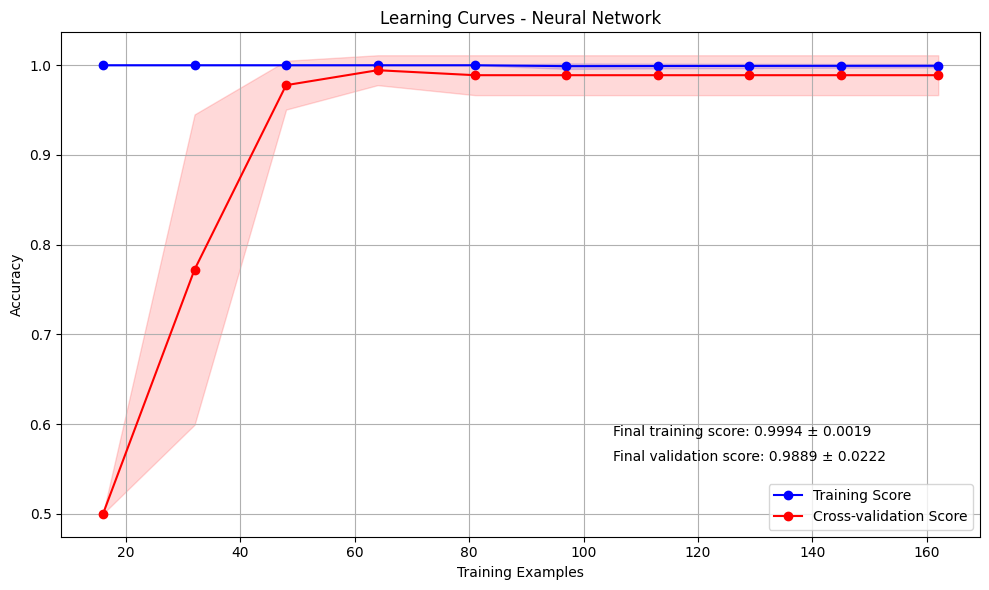


Generating learning curve for Logistic Regression...


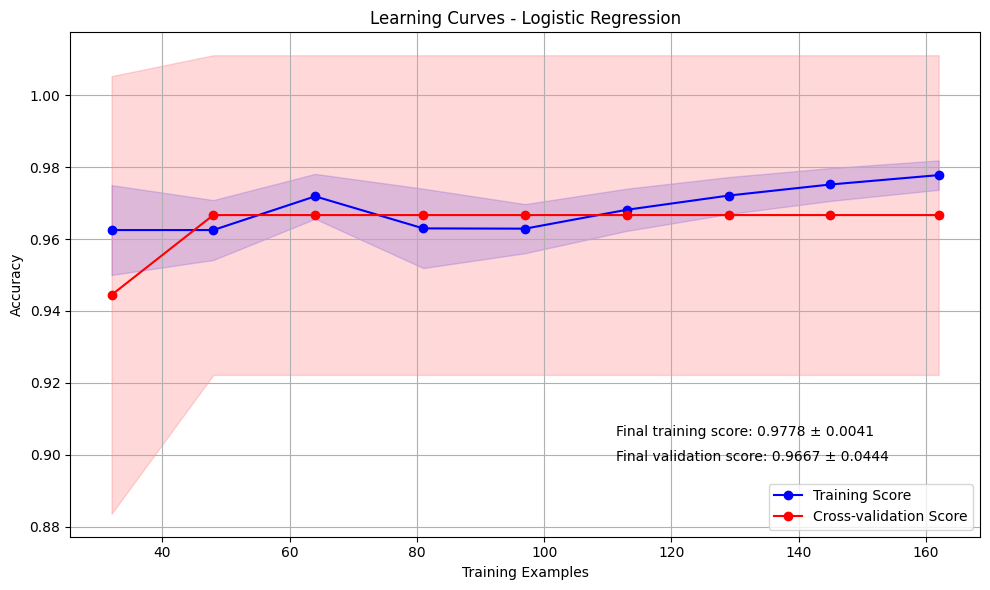


Analysis complete!


In [50]:
# Main Execution
if __name__ == "__main__":
    # 1. Prepare Data
    X_with_storage, X_without_storage, y_product, class_labels = prepare_data()
    
    # 2. Load Models
    print("Loading best parameters and creating models...")
    best_params = load_best_parameters()
    models_with_storage = create_models(best_params, 'with_storage_condition')
    models_without_storage = create_models(best_params, 'without_storage_condition')
    
    # 3. Evaluate Models
    print("\nEvaluating models with storage condition...")
    results_with_storage = evaluate_models(X_with_storage, y_product, models_with_storage)
    
    print("\nEvaluating models without storage condition...")
    results_without_storage = evaluate_models(X_without_storage, y_product, models_without_storage)
    
    # 4. Generate Visualizations and Analysis
    print("\nGenerating visualizations and analysis...")
    
    # Model comparison plot
    plot_model_comparison(results_without_storage, results_with_storage)
    
    # Confusion matrices
    plot_confusion_matrices(results_without_storage, results_with_storage, class_labels)
    
    # Statistical analysis
    stats_results = perform_statistical_analysis(results_without_storage, results_with_storage)
    
    # Save analysis summary
    save_analysis_summary(results_without_storage, results_with_storage, stats_results)

    # Learning curves
    for model_name, model in models_with_storage.items():
        print(f"\nGenerating learning curve for {model_name}...")
        plot_learning_curves(X_with_storage, y_product, model, model_name)
    
    print("\nAnalysis complete!")